# **CLV**

In [ ]:
%pip install lifetimes
%pip install seaborn
%pip install scikit-learn
import lifetimes
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes import BetaGeoFitter, GammaGammaFitter
from google.colab import drive
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.utils import summary_data_from_transaction_data
from sklearn.preprocessing import MinMaxScaler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset
df = pd.read_csv( '/content/drive/Shareddrives/HK hè/Phân tích dữ liệu thương mại điện tử/DATA+CODE/Processed_Retail_Transaction_Dataset.csv')
df.head()

,CustomerID,TransactionDate,TotalAmount,Price,Quantity,recency,frequency,monetary_value
0,109318,2023-12-26 12:32:00,455.862764,80.079844,7,124,1,455.862764
1,993229,2023-08-05 00:00:00,258.306546,75.195229,4,268,1,258.306546
2,579675,2024-03-11 18:51:00,212.015651,31.528816,8,48,1,212.015651
3,799826,2023-10-27 22:00:00,461.343769,98.880218,5,184,1,461.343769
4,121413,2023-12-22 11:38:00,626.030484,93.188512,7,25,2,897.686656


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerID       100000 non-null  int64  
 1   TransactionDate  100000 non-null  object 
 2   TotalAmount      100000 non-null  float64
 3   Price            100000 non-null  float64
 4   Quantity         100000 non-null  int64  
 5   recency          100000 non-null  int64  
 6   frequency        100000 non-null  int64  
 7   monetary_value   100000 non-null  float64
dtypes: float64(3), int64(4), object(1)
memory usage: 6.1+ MB


In [ ]:
df.describe()

,CustomerID,TotalAmount,Price,Quantity,recency,frequency,monetary_value
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000
mean,500463.982180,248.334955,55.067344,5.009290,175.94538,1.099040,272.842842
std,288460.917524,184.554792,25.971567,2.579808,105.22641,0.315329,208.265166
min,14.000000,8.274825,10.000430,1.000000,0.00000,1.000000,8.274825
25%,250693.750000,95.163418,32.549474,3.000000,84.00000,1.000000,104.298071
50%,499679.000000,200.368393,55.116789,5.000000,173.00000,1.000000,220.814516
75%,751104.750000,362.009980,77.456763,7.000000,266.00000,1.000000,395.665032
max,999997.000000,896.141242,99.999284,9.000000,365.00000,4.000000,2002.072661


In [ ]:
# Ensure TransactionDate is in datetime format
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

# Calculate the total price, in this dataset, the total amount = price * quantity - discount
df['Total Price'] = df['TotalAmount']

In [ ]:
# Check the maximum TransactionDate in the dataset
max_transaction_date = df['TransactionDate'].max()
print(f"Maximum TransactionDate: {max_transaction_date}")

Maximum TransactionDate: 2024-04-28 22:22:00


In [ ]:
# Define observation period end
observation_period_end = pd.Timestamp('2024-04-29')

# Calculate the age of the customer in the dataset (T)
df['T'] = (observation_period_end - df.groupby('CustomerID')['TransactionDate'].transform('min')).dt.days

# Sort the dataset by CustomerID
sorted_df = df.sort_values(by='CustomerID')

# Select the relevant columns: R, F, M, and T
rfm_t_df = sorted_df[['CustomerID', 'recency', 'frequency', 'monetary_value', 'T']]

# Display the R, F, M, and T columns sorted by CustomerID
rfm_t_df.head()

,CustomerID,recency,frequency,monetary_value,T
82921,14,266,1,256.232791,266
81540,42,345,1,502.656523,345
26140,49,328,1,21.399047,328
59546,59,27,2,249.492696,253
59545,59,27,2,249.492696,253


In [ ]:
rfm_t_df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,100000.0,500463.982180,288460.917524,14.000000,250693.750000,499679.000000,751104.750000,999997.000000
recency,100000.0,175.945380,105.226410,0.000000,84.000000,173.000000,266.000000,365.000000
frequency,100000.0,1.099040,0.315329,1.000000,1.000000,1.000000,1.000000,4.000000
monetary_value,100000.0,272.842842,208.265166,8.274825,104.298071,220.814516,395.665032,2002.072661
T,100000.0,187.753750,105.219371,0.000000,97.000000,190.000000,280.000000,365.000000


## **Frequency/Recency Analysis using the BG/NBD Model**

In [ ]:
# Fit the BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(rfm_t_df['frequency'], rfm_t_df['recency'], rfm_t_df['T'])

<lifetimes.BetaGeoFitter: fitted with 100000 subjects, a: 1.56, alpha: 8513.89, b: 16.10, r: 50.96>

In [ ]:
# Predict future customer transactions for 10 days
predicted_purchases = bgf.predict(10, rfm_t_df['frequency'],rfm_t_df['recency'], rfm_t_df['T'])

# Display the predicted purchases for each customer
rfm_t_df['predicted_purchases'] = predicted_purchases
print(rfm_t_df[['frequency', 'recency', 'T', 'predicted_purchases']].head())

       frequency  recency    T  predicted_purchases
82921          1      266  266             0.053819
81540          1      345  345             0.053341
26140          1      328  328             0.053443
59546          2       27  253             0.044198
59545          2       27  253             0.044198


In [ ]:
# Predict future customer transactions for 30 days
predicted_purchases = bgf.predict(30, rfm_t_df['frequency'],rfm_t_df['recency'], rfm_t_df['T'])

# Display the predicted purchases for each customer
rfm_t_df['predicted_purchases'] = predicted_purchases
print(rfm_t_df[['frequency', 'recency', 'T', 'predicted_purchases']].head())

       frequency  recency    T  predicted_purchases
82921          1      266  266             0.160652
81540          1      345  345             0.159230
26140          1      328  328             0.159533
59546          2       27  253             0.131954
59545          2       27  253             0.131954


In [ ]:
# Predict future customer transactions for 60 days
predicted_purchases = bgf.predict(60, rfm_t_df['frequency'],rfm_t_df['recency'], rfm_t_df['T'])

# Display the predicted purchases for each customer
rfm_t_df['predicted_purchases'] = predicted_purchases
print(rfm_t_df[['frequency', 'recency', 'T', 'predicted_purchases']].head())

       frequency  recency    T  predicted_purchases
82921          1      266  266             0.318914
81540          1      345  345             0.316112
26140          1      328  328             0.316711
59546          2       27  253             0.262006
59545          2       27  253             0.262006


In [ ]:
# Predict future customer transactions for 90 days
predicted_purchases = bgf.predict(90, rfm_t_df['frequency'],rfm_t_df['recency'], rfm_t_df['T'])

# Display the predicted purchases for each customer
rfm_t_df['predicted_purchases'] = predicted_purchases
print(rfm_t_df[['frequency', 'recency', 'T', 'predicted_purchases']].head())

       frequency  recency    T  predicted_purchases
82921          1      266  266             0.474844
81540          1      345  345             0.470703
26140          1      328  328             0.471588
59546          2       27  253             0.390201
59545          2       27  253             0.390201


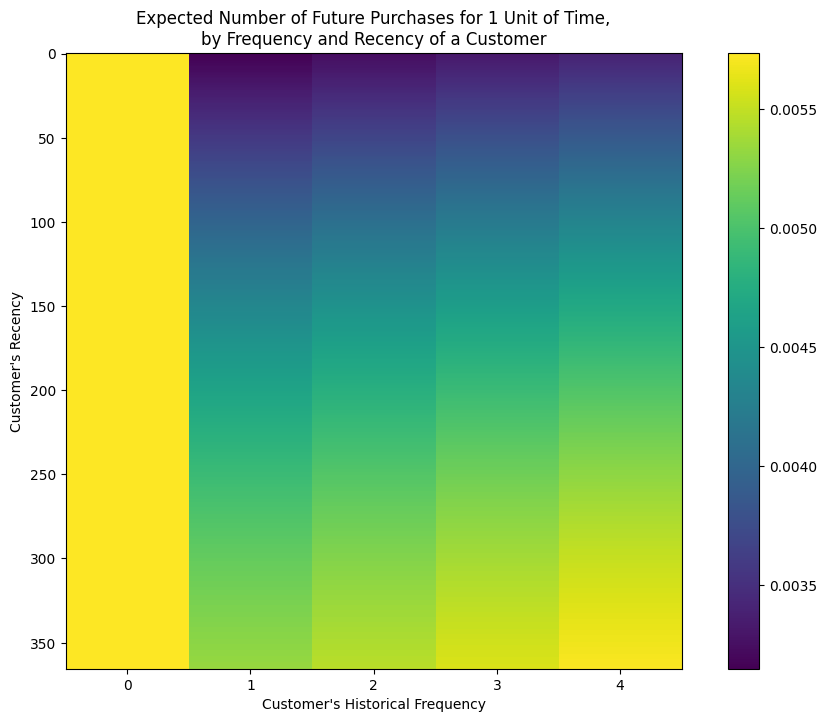

In [ ]:
# Plot frequency recency matrix
plt.figure(figsize=(12, 8))
from lifetimes.plotting import plot_frequency_recency_matrix
plot_frequency_recency_matrix(bgf)
plt.show()

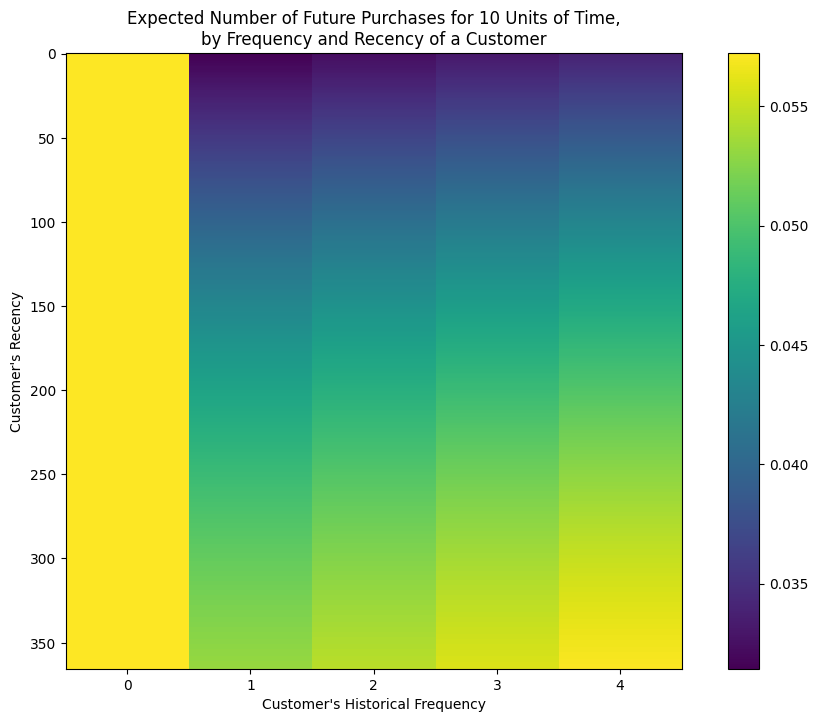

In [ ]:
# Plot frequency recency matrix for 10 units of time
plt.figure(figsize=(12, 8))
plot_frequency_recency_matrix(bgf, T=10)
plt.show()

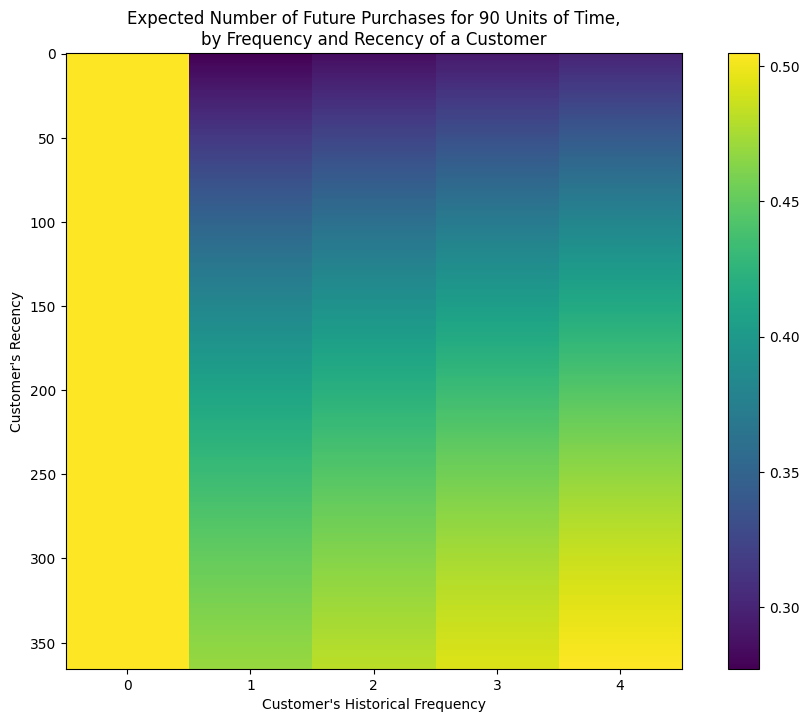

In [ ]:
# Plot frequency recency matrix for 90 units of time
plt.figure(figsize=(12, 8))
plot_frequency_recency_matrix(bgf, T=90)
plt.show()

# **Gamma-gamma model**

In [ ]:
# Fit the Gamma-Gamma model
ggf = GammaGammaFitter(penalizer_coef=1e-06)
ggf.fit(rfm_t_df['frequency'], rfm_t_df['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 100000 subjects, p: 3.21, q: 2.37, v: 134.97>

In [ ]:
# Predict the expected average monetary value of transactions
rfm_t_df['predicted_monetary_value'] = ggf.conditional_expected_average_profit(rfm_t_df['frequency'], rfm_t_df['monetary_value'])
# Display the predicted monetary value for each customer
print(rfm_t_df[['frequency', 'monetary_value', 'predicted_monetary_value']].head())

       frequency  monetary_value  predicted_monetary_value
82921          1      256.232791                274.405312
81540          1      502.656523                447.256560
26140          1       21.399047                109.683735
59546          2      249.492696                261.356094
59545          2      249.492696                261.356094


In [ ]:
# Calculate the customer lifetime value (CLV)
rfm_t_df['CLV'] = ggf.customer_lifetime_value(
    bgf,
    rfm_t_df['frequency'],
    rfm_t_df['recency'],
    rfm_t_df['T'],
    rfm_t_df['monetary_value'],
    time=6,  # months
    discount_rate=0.01  # monthly discount rate
)

In [ ]:
# Load the cluster dataset
cluster_df = pd.read_csv('/content/drive/Shareddrives/HK hè/Phân tích dữ liệu thương mại điện tử/DATA+CODE/cluster_customer.csv')

# Merge the RFM dataset with the cluster dataset based on CustomerID
merged_df = pd.merge(rfm_t_df, cluster_df, on='CustomerID')

# Remove duplicate rows
merged_df = merged_df.drop_duplicates()

# Display the merged dataset
print(merged_df.head())

   CustomerID  recency  frequency  monetary_value    T  predicted_purchases  \
0          14      266          1      256.232791  266             0.474844   
1          42      345          1      502.656523  345             0.470703   
2          49      328          1       21.399047  328             0.471588   
3          59       27          2      249.492696  253             0.390201   
5          65      315          1      548.006625  315             0.472267   

   predicted_monetary_value         CLV  Cluster  
0                274.405312  246.383386        2  
1                447.256560  398.153871        2  
2                109.683735   97.821715        1  
3                261.356094  192.962398        0  
5                479.066896  427.859383        2  


In [ ]:
# Identify the top 10 customers by CLV
top_10_customers = merged_df.nlargest(10, 'CLV')

# Predict purchases for the next 10, 30, 60, and 90 days for top 10 customers
time_periods = [10, 30, 60, 90]
predictions = {time: bgf.predict(time, top_10_customers['frequency'], top_10_customers['recency'], top_10_customers['T']) for time in time_periods}

# Add the predictions to the top 10 customers DataFrame
for time in time_periods:
    top_10_customers[f'predicted_purchases_{time}_days'] = predictions[time]

# Display the results
print(top_10_customers[['CustomerID', 'Cluster','recency', 'frequency', 'monetary_value', 'T', 'CLV', 'predicted_purchases_10_days', 'predicted_purchases_30_days', 'predicted_purchases_60_days', 'predicted_purchases_90_days']])

       CustomerID  Cluster  recency  frequency  monetary_value    T  \
3224        32895        0      231          3     2002.072661  301   
98066      980072        0      263          3     1636.196111  276   
79530      796166        0       53          3     1647.517063  148   
90310      903169        0       29          2     1563.851160   44   
34128      340516        0        1          4     1604.858454  205   
77893      780013        0      191          2     1519.193458  233   
82324      823783        0      127          3     1441.329882  265   
96800      967685        0      155          3     1405.556678  272   
80511      805930        0       66          2     1333.753391   85   
88828      887487        0       29          2     1352.743062   82   

               CLV  predicted_purchases_10_days  predicted_purchases_30_days  \
3224   1617.250113                     0.053929                     0.161031   
98066  1379.483965                     0.056017           

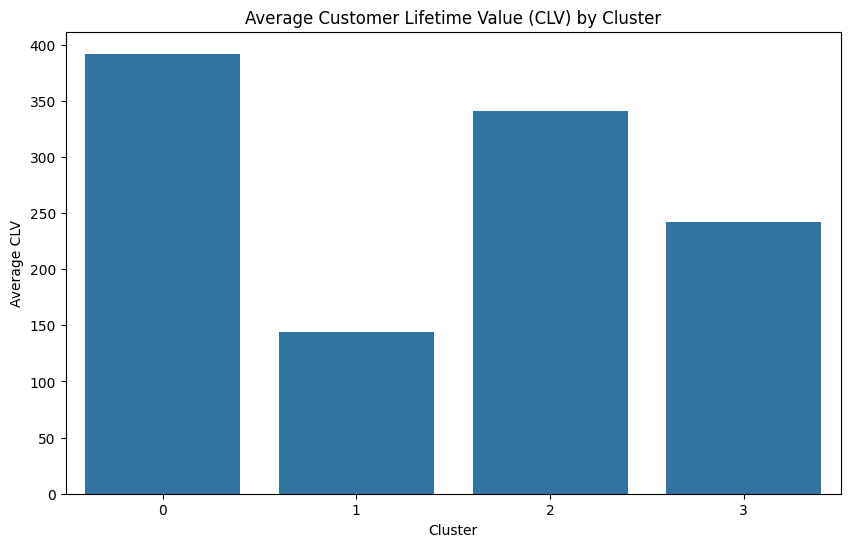

In [ ]:
# Visualize CLV for each cluster
cluster_clv = merged_df.groupby('Cluster')['CLV'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='CLV', data=cluster_clv)
plt.title('Average Customer Lifetime Value (CLV) by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average CLV')
plt.show()